In [1]:
#Mohammed Farees Patel (HoneWork -3)

# LVQ for the Ionosphere Dataset
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import pylab as pl
import random
import timeit

#SVM
import pandas as pd
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
% matplotlib inline


global train_start, test_start, test_end


In [2]:
# Load a CSV file
def load_csv(filename):
	dataset=list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

In [3]:
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

In [4]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

plot_roc=list()

 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		plot_roc.append((actual, predicted))
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores
 
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)
 
# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
	distances = list()
	for codebook in codebooks:
		dist = euclidean_distance(codebook, test_row)
		distances.append((codebook, dist))
	distances.sort(key=lambda tup: tup[1])
	return distances[0][0]
 
# Make a prediction with codebook vectors
def predict(codebooks, test_row):
	bmu = get_best_matching_unit(codebooks, test_row)
	return bmu[-1]
 
# Create a random codebook vector
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook
 
# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
	codebooks = [random_codebook(train) for i in range(n_codebooks)]
	for epoch in range(epochs):
		rate = lrate * (1.0-(epoch/float(epochs)))
		sum_error = 0.0
		for row in train:
			bmu = get_best_matching_unit(codebooks, row)
			for i in range(len(row)-1):
				error = row[i] - bmu[i]
				sum_error += error**2
				if bmu[-1] == row[-1]:
					bmu[i] += rate * error
				else:
					bmu[i] -= rate * error
#		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, rate, sum_error))
	return codebooks
 
# LVQ Algorithm
def learning_vector_quantization(train, test, n_codebooks, lrate, epochs):
	codebooks = train_codebooks(train, n_codebooks, lrate, epochs)
	predictions = list()
	for row in test:
		output = predict(codebooks, row)
		predictions.append(output)
	return(predictions)

In [5]:
# Test LVQ on Ionosphere dataset
#seed(1)
# load and prepare data
filename = 'C:/Users/Farees Patel/Desktop/ionosphere.csv'
dataset = load_csv(filename)

In [6]:
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

{'0': 0, '1': 1}

In [7]:
lvq_parameters={'learning_Rate': list(pl.frange(0.1,1,0.1)),
              'Number of Codebook': list(range(5,25,5)),
            'Number of epoch': list(range(50,300,50))}

In [10]:
n_folds = 5
accuracy=list()

with open("batch_file.txt", "w") as output:
    for learn_rate in lvq_parameters['learning_Rate']:
        for n_codebooks in lvq_parameters['Number of Codebook']:
            for n_epochs in lvq_parameters['Number of epoch']:
                scores = evaluate_algorithm(dataset, learning_vector_quantization, n_folds, n_codebooks, learn_rate, n_epochs)
                accuracy.append((learn_rate, n_codebooks, n_epochs, sum(scores)/float(len(scores))))
                output.write(str(accuracy))
                output.write(str("\n"))
                print ("learning_Rate: %.2f\t" "Number of Codebook: %d \t\t" "Number of epoch: %d \t\t" "Mean Accuracy: %0.3f%% \t\t" % (learn_rate, n_codebooks, n_epochs, (sum(scores)/float(len(scores)))))            


In [691]:
import ast

with open('C:/Users/Farees Patel/Desktop/batch_file.txt') as f:
    lines = f.read().splitlines()

x=ast.literal_eval(lines[-1])
r=list()
for i in x:
    r.append(tuple(i))
    
r.sort(key=lambda tup: tup[3], reverse=True)
print("LVQ best parameters: l_rate=%.2f\t n_codebook=%d\t n_epochs=%d" % (r[1][0],r[1][1],r[1][2]))

LVQ best parameters: l_rate=0.30	 n_codebook=20	 n_epochs=250


In [707]:
l_rate=list()
n_codebook=list()
n_epoch=list()
acc=list()

for i in r:
    if(i[0]==0.30000000000000004 and i[1]==20):
        #l_rate.append(i[0])
        #n_codebook.append(i[1])
        n_epoch.append(i[2])
        acc.append(i[3]) 

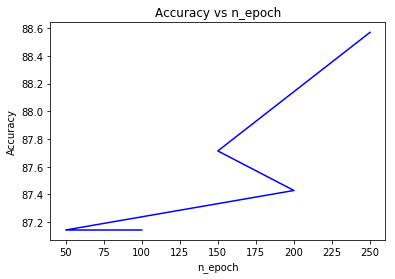

In [708]:
%matplotlib inline
fig,ax = plt.subplots(1)
#fig, ax2=plot.subplot(2)

x1 = np.array(n_epoch)
y1 = np.array(acc)
# plot the data
#ax.plot(x1,y1)
plt.plot(x1, y1, 'b')
plt.ylabel('Accuracy')
plt.xlabel('n_epoch')
plt.title("Accuracy vs n_epoch")
plt.show() 

In [ ]:
##SVM

In [15]:
import pandas as pd
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

In [106]:
svm_dataset=np.array(train_set)

In [107]:

X=svm_dataset[:,:-1]
y=svm_dataset[:,-1]

# shuffle the dataset
X, y = shuffle(X, y, random_state=0)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Set the parameters by cross-validation
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                'C': [1, 10, 100, 1000]},
              {'kernel': ['poly'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

print("# Tuning hyper-parameters")
print()

clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on training set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on training set:

0.647 (+/-0.008) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.647 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.837 (+/-0.095) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.951 (+/-0.063) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.951 (+/-0.054) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.935 (+/-0.082) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.647 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.853 (+/-0.120) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.918 (+/-0.091) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.940 (+/-0.079) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.935 (+/-0.044) for {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.940 (+/-0.072) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.848 (+/-0.115) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.913 (+/-0.105) for {'C': 100, 'gamma'

In [709]:
C=list()
gamma=list()
kernel=list
acc=list()

for i, a in zip(clf.cv_results_['params'], means):
    if(i["kernel"]=="rbf" and i["C"]==1):
        #C.append(i["C"])
        gamma.append(i["gamma"])
        acc.append(a)   

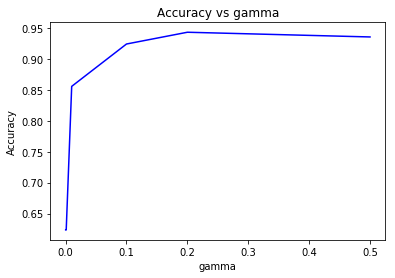

In [710]:
%matplotlib inline
fig,ax = plt.subplots(1)
#fig, ax2=plot.subplot(2)

x1 = np.array(gamma)
y1 = np.array(acc)
# plot the data
#ax.plot(x1,y1)
plt.plot(x1, y1, 'b')
plt.ylabel('Accuracy')
plt.xlabel('gamma')
plt.title("Accuracy vs gamma")
plt.show()

In [ ]:
#Backpropagation

In [8]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)

In [9]:
bp_parameters={'learning_Rate': list(pl.frange(0.1,0.8,0.1)),
              'Hidden Layer': list(range(5,10,1)),
            'Number of epoch': list(range(500,1000,200))}

In [ ]:
n_folds = 5
accuracy=list()

with open("bp_file.txt", "w") as output:
    for l_rate in bp_parameters['learning_Rate']:
        for n_hidden in bp_parameters['Hidden Layer']:
            for n_epoch in bp_parameters['Number of epoch']:
                scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
                accuracy.append((l_rate, n_hidden, n_epoch, sum(scores)/float(len(scores))))
                output.write(str(accuracy))
                output.write(str("\n"))
                print ("learning_Rate: %.2f\t" "Number of Hidden Layer: %d \t\t" "Number of epoch: %d \t\t" "Mean Accuracy: %0.3f%% \t\t" % (l_rate, n_hidden, n_epoch, (sum(scores)/float(len(scores)))))            


In [716]:
import ast

with open('C:/Users/Farees Patel/Desktop/bp_file.txt') as f:
    lines = f.read().splitlines()

x=ast.literal_eval(lines[-1])
r=list()
for i in x:
    r.append(tuple(i))
    
r.sort(key=lambda tup: tup[3], reverse=True)
print("Back propagation best parameters: l_rate=%.2f\t n_hidden=%d\t n_epochs=%d" % (r[1][0],r[1][1],r[1][2]))

Back propagation best parameters: l_rate=0.70	 n_hidden=8	 n_epochs=900


In [725]:
l_rate=list()
n_hidden=list()
n_epoch=list()
acc=list()

for i in r:
    if(i[2]==900 and i[1]==8):
        l_rate.append(i[0])
        #n_hidden.append(i[1])
        #n_epoch.append(i[2])
        acc.append(i[3]) 

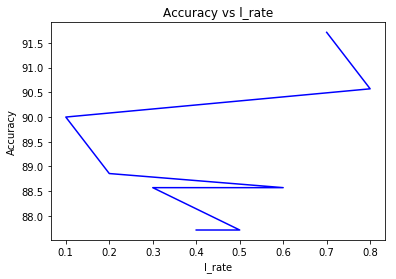

In [728]:
%matplotlib inline
fig,ax = plt.subplots(1)
#fig, ax2=plot.subplot(2)

x1 = np.array(l_rate)
y1 = np.array(acc)
# plot the data
#ax.plot(x1,y1)
plt.plot(x1, y1, 'b')
plt.ylabel('Accuracy')
plt.xlabel('l_rate')
plt.title("Accuracy vs l_rate")
plt.show()

In [729]:
#LVQ with best model parameters

In [15]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(train_set,test_set, algorithm, *args):
	test_y=list()
	for row in test_set:
		test_y.append(row[-1])
		row[-1] = None
	predicted, test_start = algorithm(train_set, test_set, *args)
	test_end = timeit.default_timer()
	actual = [row for row in test_y]
	plot_roc.append((actual, predicted))
	accuracy = accuracy_metric(actual, predicted)
	return accuracy, test_start, test_end

 
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)
 
# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
	distances = list()
	for codebook in codebooks:
		dist = euclidean_distance(codebook, test_row)
		distances.append((codebook, dist))
	distances.sort(key=lambda tup: tup[1])
	return distances[0][0]
 
# Make a prediction with codebook vectors
def predict(codebooks, test_row):
	bmu = get_best_matching_unit(codebooks, test_row)
	return bmu[-1]
 
# Create a random codebook vector
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook
 
# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
	codebooks = [random_codebook(train) for i in range(n_codebooks)]
	for epoch in range(epochs):
		rate = lrate * (1.0-(epoch/float(epochs)))
		sum_error = 0.0
		for row in train:
			bmu = get_best_matching_unit(codebooks, row)
			for i in range(len(row)-1):
				error = row[i] - bmu[i]
				sum_error += error**2
				if bmu[-1] == row[-1]:
					bmu[i] += rate * error
				else:
					bmu[i] -= rate * error
#		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, rate, sum_error))
	return codebooks
 
# LVQ Algorithm
def learning_vector_quantization(train, test, n_codebooks, lrate, epochs):
	codebooks = train_codebooks(train, n_codebooks, lrate, epochs)
	predictions = list()
	test_start = timeit.default_timer()
	for row in test:
		output = predict(codebooks, row)
		predictions.append(output)
	return(predictions, test_start)

In [55]:
filename = 'C:/Users/Farees Patel/Desktop/ionosphere.csv'
dataset = load_csv(filename)

for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

{'0': 0, '1': 1}

In [56]:
import random
variable = [0,1]
dataset_index=[index for index in range(len(dataset))]
train_index=random.sample(range(0, len(dataset)-1), round(0.7*len(dataset)))
test_index=set(dataset_index)-set(train_index)
for i in dataset:
    if(i[-1]==None):
        i[-1]=random.choice(variable)
train_set=[dataset[x] for x in train_index]
test_set=[dataset[x] for x in test_index]

In [88]:
import csv

with open("train.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(train_set)

with open("test.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(test_set)

In [3]:
import csv
with open('train.csv', 'r') as f:
    reader = csv.reader(f)
    train_set = list(reader)

with open('test.csv', 'r') as f:
    reader = csv.reader(f)
    test_set = list(reader)

test_set=[x for x in test_set if x != []]
train_set=[x for x in train_set if x != []]

train_set=[[float(j) for j in i] for i in train_set]
test_set=[[float(j) for j in i] for i in test_set]

for u,v in zip(train_set,test_set):
    u[-1],v[-1]=int(u[-1]),int(v[-1])

In [98]:
# evaluate algorithm
plot_roc=list()
train_start = timeit.default_timer()
learn_rate = 0.3
n_epochs = 20
n_codebooks = 250
scores, test_start, test_end = evaluate_algorithm(train_set,test_set, learning_vector_quantization, n_codebooks, learn_rate, n_epochs)

LVQ accuracy: 81.905
LVQ Algorithm: Area under the curve: 0.797
Training Time: 12.5959 seconds
Training Time: 0.2666seconds

Confusion Matrix

 [[29 15]
 [ 4 57]]


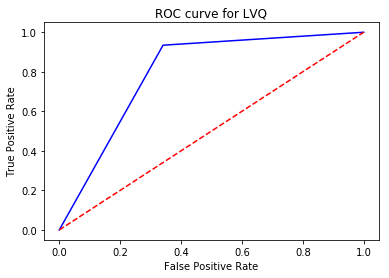

Detailed classification report:
             precision    recall  f1-score   support

          0       0.88      0.66      0.75        44
          1       0.79      0.93      0.86        61

avg / total       0.83      0.82      0.81       105



In [101]:
fpr, tpr, _ = roc_curve(plot_roc[0][0], plot_roc[0][1])
acc=accuracy_score(plot_roc[0][0], plot_roc[0][1])*100
train_time=test_start-train_start
test_time=test_end-test_start
print("LVQ accuracy: %.3f" % acc)
print( "LVQ Algorithm: Area under the curve: %0.3f" % auc(fpr, tpr))
print("Training Time: %.4f seconds" %train_time)
print("Training Time: %.4fseconds" % test_time)

print("\nConfusion Matrix\n\n",confusion_matrix(plot_roc[0][0], plot_roc[0][1]))
np.set_printoptions(precision=2)

plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve for LVQ")
plt.show()

print("Detailed classification report:")
print(classification_report(plot_roc[0][0], plot_roc[0][1]))



In [730]:
#SVM with best model parameters

In [108]:
svm_dataset=np.array(train_set)
X_train=svm_dataset[:,:-1]
y_train=svm_dataset[:,-1]

svm_dataset=np.array(test_set)
X_test=svm_dataset[:,:-1]
y_test=svm_dataset[:,-1]

SVM accuracy: 90.476%
SVM Algorithm: Area under the curve: 0.902
Training Time: 0.0050 seconds
Testing Time: 0.0009seconds

Confusion Matrix

 [[39  5]
 [ 5 56]]


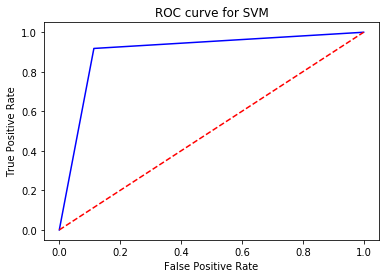

Detailed classification report:
             precision    recall  f1-score   support

        0.0       0.89      0.89      0.89        44
        1.0       0.92      0.92      0.92        61

avg / total       0.90      0.90      0.90       105



In [109]:
train_start = timeit.default_timer()

clf = svm.SVC(C= 1, gamma= 0.2, kernel= 'rbf')
clf.fit(X_train, y_train)

test_start = timeit.default_timer()

predicted=clf.predict(X_test)

test_end = timeit.default_timer()

acc=accuracy_score(y_test, predicted)*100

train_time=test_start-train_start
test_time=test_end-test_start

fpr, tpr, _ = roc_curve(y_test, predicted)
print("SVM accuracy: %.3f%%" % acc)
print( "SVM Algorithm: Area under the curve: %0.3f" % auc(fpr, tpr))
print("Training Time: %.4f seconds" %train_time)
print("Testing Time: %.4fseconds" % test_time)
print("\nConfusion Matrix\n\n",confusion_matrix(y_test, predicted))
np.set_printoptions(precision=2)

plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve for SVM")
plt.show()

print("Detailed classification report:")
print(classification_report(y_test, predicted))

In [731]:
#Backpropagation with best model parameters

In [6]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from math import exp


# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

plot_roc=list()

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(train_set, test_set, algorithm, *args):
	test_y=list()
	for row in test_set:
		test_y.append(row[-1])
		row[-1] = None
	predicted, test_start = algorithm(train_set, test_set, *args)
	actual = [row for row in test_y]
	test_end = timeit.default_timer()
	plot_roc.append((actual, predicted))
	accuracy = accuracy_metric(actual, predicted)
	return accuracy, test_start, test_end

# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[int(row[-1])] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random.random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random.random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	test_start = timeit.default_timer()
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions, test_start)

In [528]:
#qwerty
import random

l_rate = 0.7
n_epoch = 900
n_hidden = 8

train_start = timeit.default_timer()
scores,test_start, test_end = evaluate_algorithm(train_set, test_set,back_propagation, l_rate, n_epoch, n_hidden)

Backpropagation accuracy: 82.857
Backpropagation Algorithm: Area under the curve: 0.818
Training Time: 24.3992 seconds
Testing Time: 0.0037seconds

Confusion Matrix

 [[33 11]
 [ 7 54]]


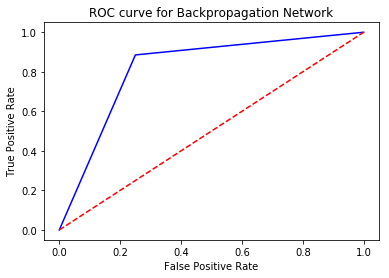

Detailed classification report:
             precision    recall  f1-score   support

          0       0.82      0.75      0.79        44
          1       0.83      0.89      0.86        61

avg / total       0.83      0.83      0.83       105



In [11]:
fpr, tpr, _ = roc_curve(plot_roc[0][0], plot_roc[0][1])
acc=accuracy_score(plot_roc[0][0], plot_roc[0][1])*100

train_time=test_start-train_start
test_time=test_end-test_start

print("Backpropagation accuracy: %.3f" % acc)
print( "Backpropagation Algorithm: Area under the curve: %0.3f" % auc(fpr, tpr))
print("Training Time: %.4f seconds" %train_time)
print("Testing Time: %.4fseconds" % test_time)
print("\nConfusion Matrix\n\n",confusion_matrix(plot_roc[0][0], plot_roc[0][1]))
np.set_printoptions(precision=2)

plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve for Backpropagation Network")
plt.show()

print("Detailed classification report:")
print(classification_report(plot_roc[0][0], plot_roc[0][1]))
